# 1) Importing and exploring EEG dataset 
### Exploring epochs (looking for 'defects' or 'bad' channels and epochs)

In [1]:
# Import packages
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.insert(0, os.path.dirname(os.getcwd()))

import mne
#%matplotlib inline
#from mayavi import mlab

In [4]:
from config import ROOT, PATH_CODE, PATH_DATA, PATH_OUTPUT

### Inspect occuring events one cnt file

In [5]:
import fnmatch
import warnings
warnings.filterwarnings('ignore')

dirs = os.listdir(PATH_DATA)
cnt_files = fnmatch.filter(dirs, "*.cnt")

# pick file:
filename = cnt_files[0]
print(filename)


# Import data and events
file = PATH_DATA + filename
data_raw = mne.io.read_raw_cnt(file, montage=None, eog='auto', preload=True)

# Band-pass filter (between 0.5 and 40 Hz. was 0.5 to 30Hz in Stober 2016)
data_raw.filter(0.5, 40, fir_design='firwin')

#events = mne.find_events(data_raw, shortest_event=0, stim_channel='STI 014', verbose=False)
events_from_annot, event_dict = mne.events_from_annotations(data_raw)

015_thomas_mmn36w.cnt
Reading 0 ... 370279  =      0.000 ...   740.558 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']


In [9]:
events_from_annot

array([[  3826,      0,      2],
       [  4552,      0,      2],
       [  5278,      0,      2],
       ...,
       [365681,      0,      2],
       [366415,      0,      2],
       [367149,      0,      2]])

In [10]:
# Chose events to keep:
event_id = [0, 1, 2] #event_id = [3, 13, 66] # select events for the given event IDs

# Chose time window:
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.8  # end of each epoch (800ms after the trigger)

# Set baseline:
baseline = (None, 0)  # means from the first instant to t = 0

In [16]:
sfreq = data_raw.info["sfreq"]
#new_events, rts = define_target_events(events, sfreq, tmin=tmin, tmax=tmax)

epochs = mne.Epochs(data_raw, events=events_from_annot, event_id=event_dict)

500 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [17]:
epochs.event_id

{'13': 1, '3': 2, '66': 3}

In [22]:
# Pick EEG channels 
picks = mne.pick_types(data_raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

epochs = mne.Epochs(data_raw, events=events_from_annot, event_id=event_dict, 
                    tmin=tmin, tmax=tmax, proj=True, picks=picks,
                    baseline=baseline, preload=True, verbose=False)

In [23]:
# Pick EOG channels 
picks_eog = mne.pick_types(data_raw.info, meg=False, eeg=False, stim=False, eog=True,
                   exclude='bads')

epochs_eog = mne.Epochs(data_raw, events=events_from_annot, event_id=event_dict, 
                        tmin=tmin, tmax=tmax, proj=True, picks=picks_eog,
                        baseline=baseline, preload=True, verbose=False)

### Pick one type of stimuli (e.g. "66") 

In [24]:
print(epochs['66'])

<Epochs  |   50 events (all good), -0.2 - 0.8 sec, baseline [None, 0], ~12.0 MB, data loaded,
 '66': 50>


### Plot average of all epochs

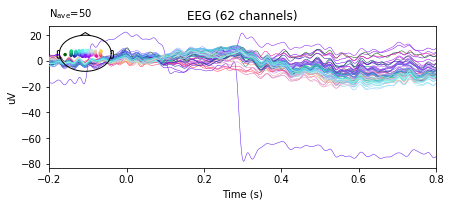

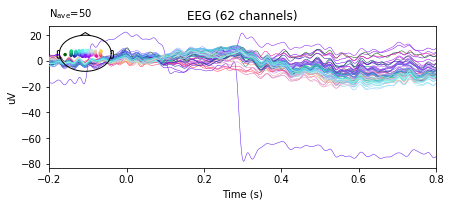

In [25]:
epochs['66'].average().plot(spatial_colors=True)

#### Something's wrong with (at least) one channel... (but it doesn't occur in each episode)

### Plot one instance of the epoch

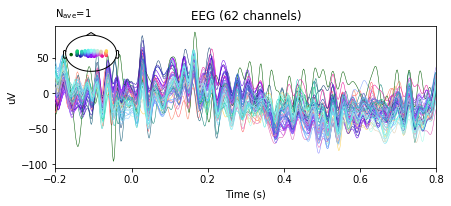

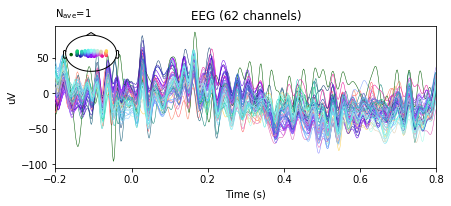

In [7]:
epochs['66'][0].average().plot(spatial_colors=True)

#### In this example channel 31 often causes problems:

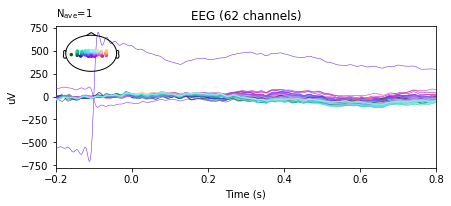

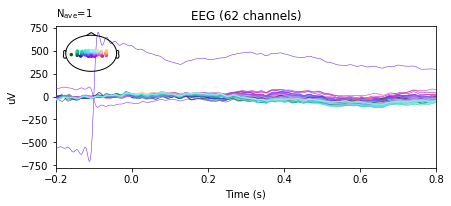

In [8]:
epochs['66'][25].average().plot(spatial_colors=True)

#### But at least at one occation problems are visible in channel 31 and 33!

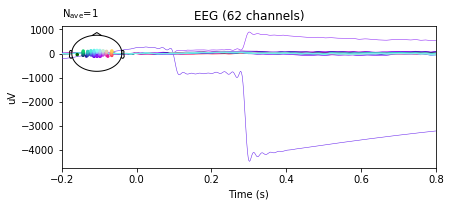

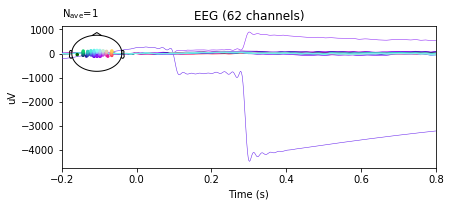

In [26]:
epochs['66'][47].average().plot(spatial_colors=True)

### Plot all individual instances of an epoch

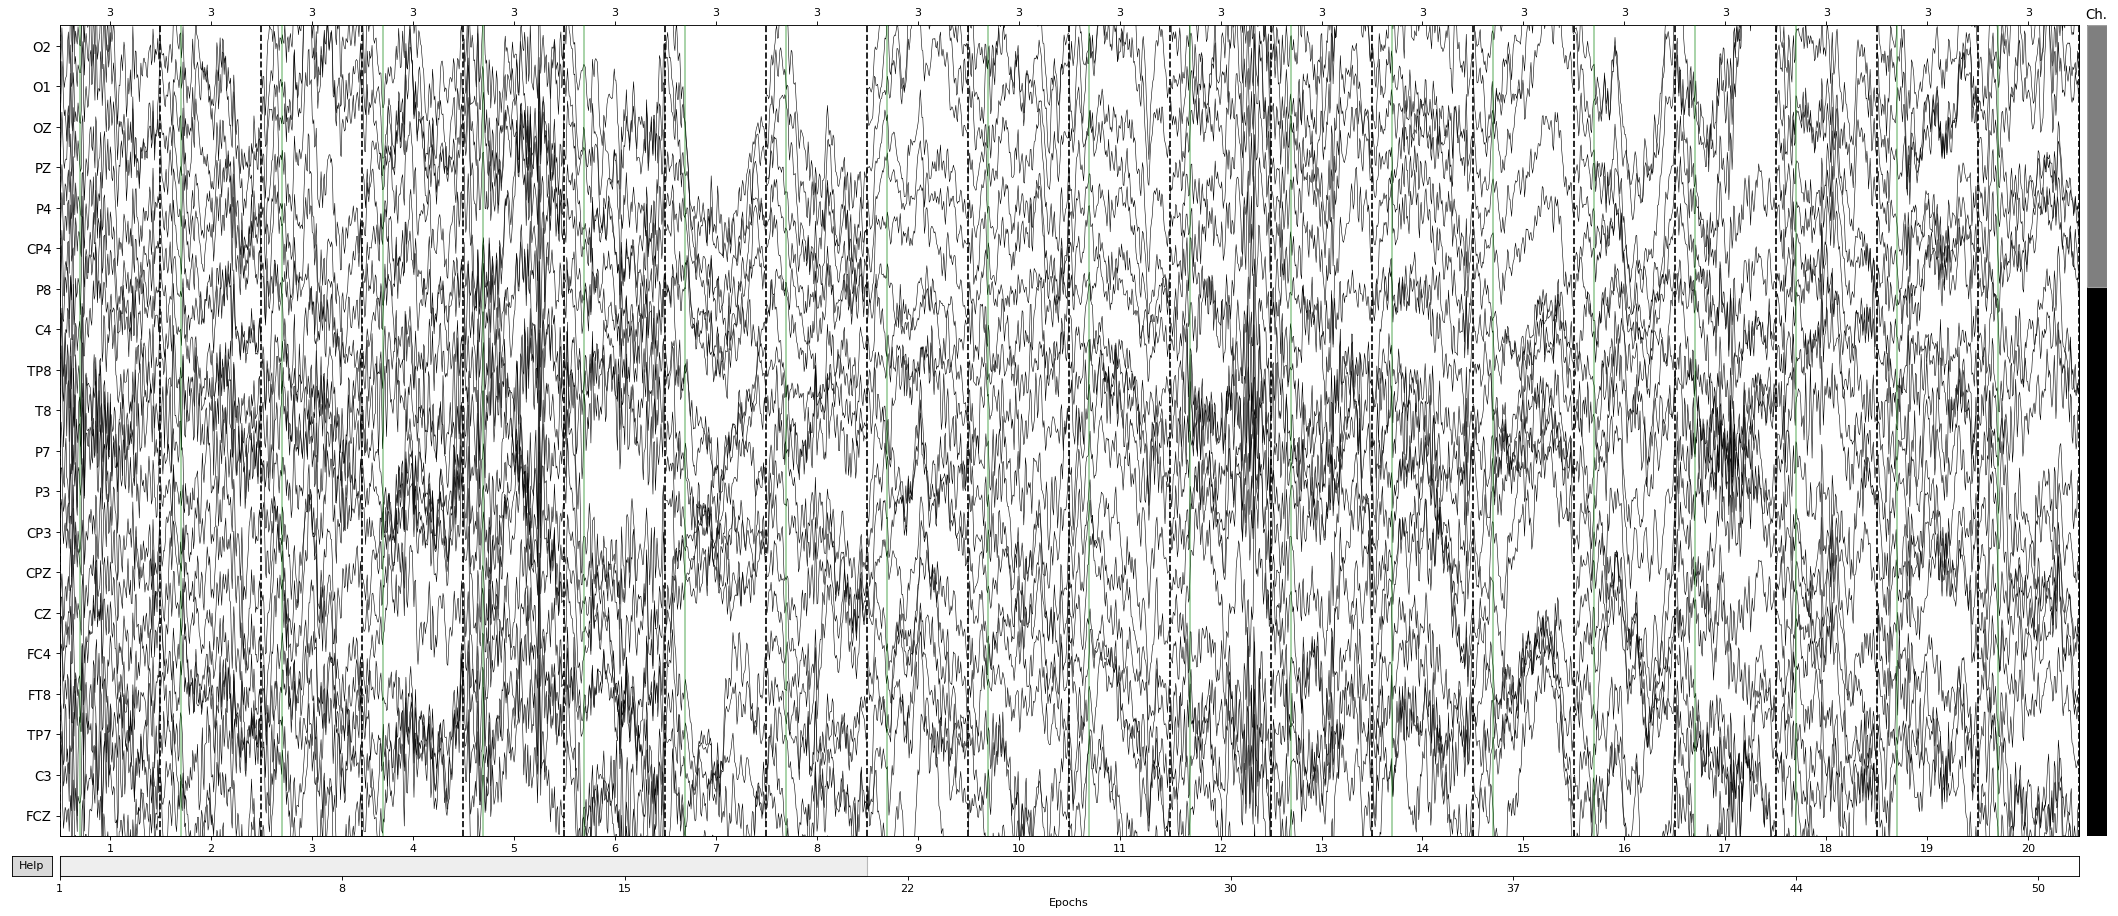

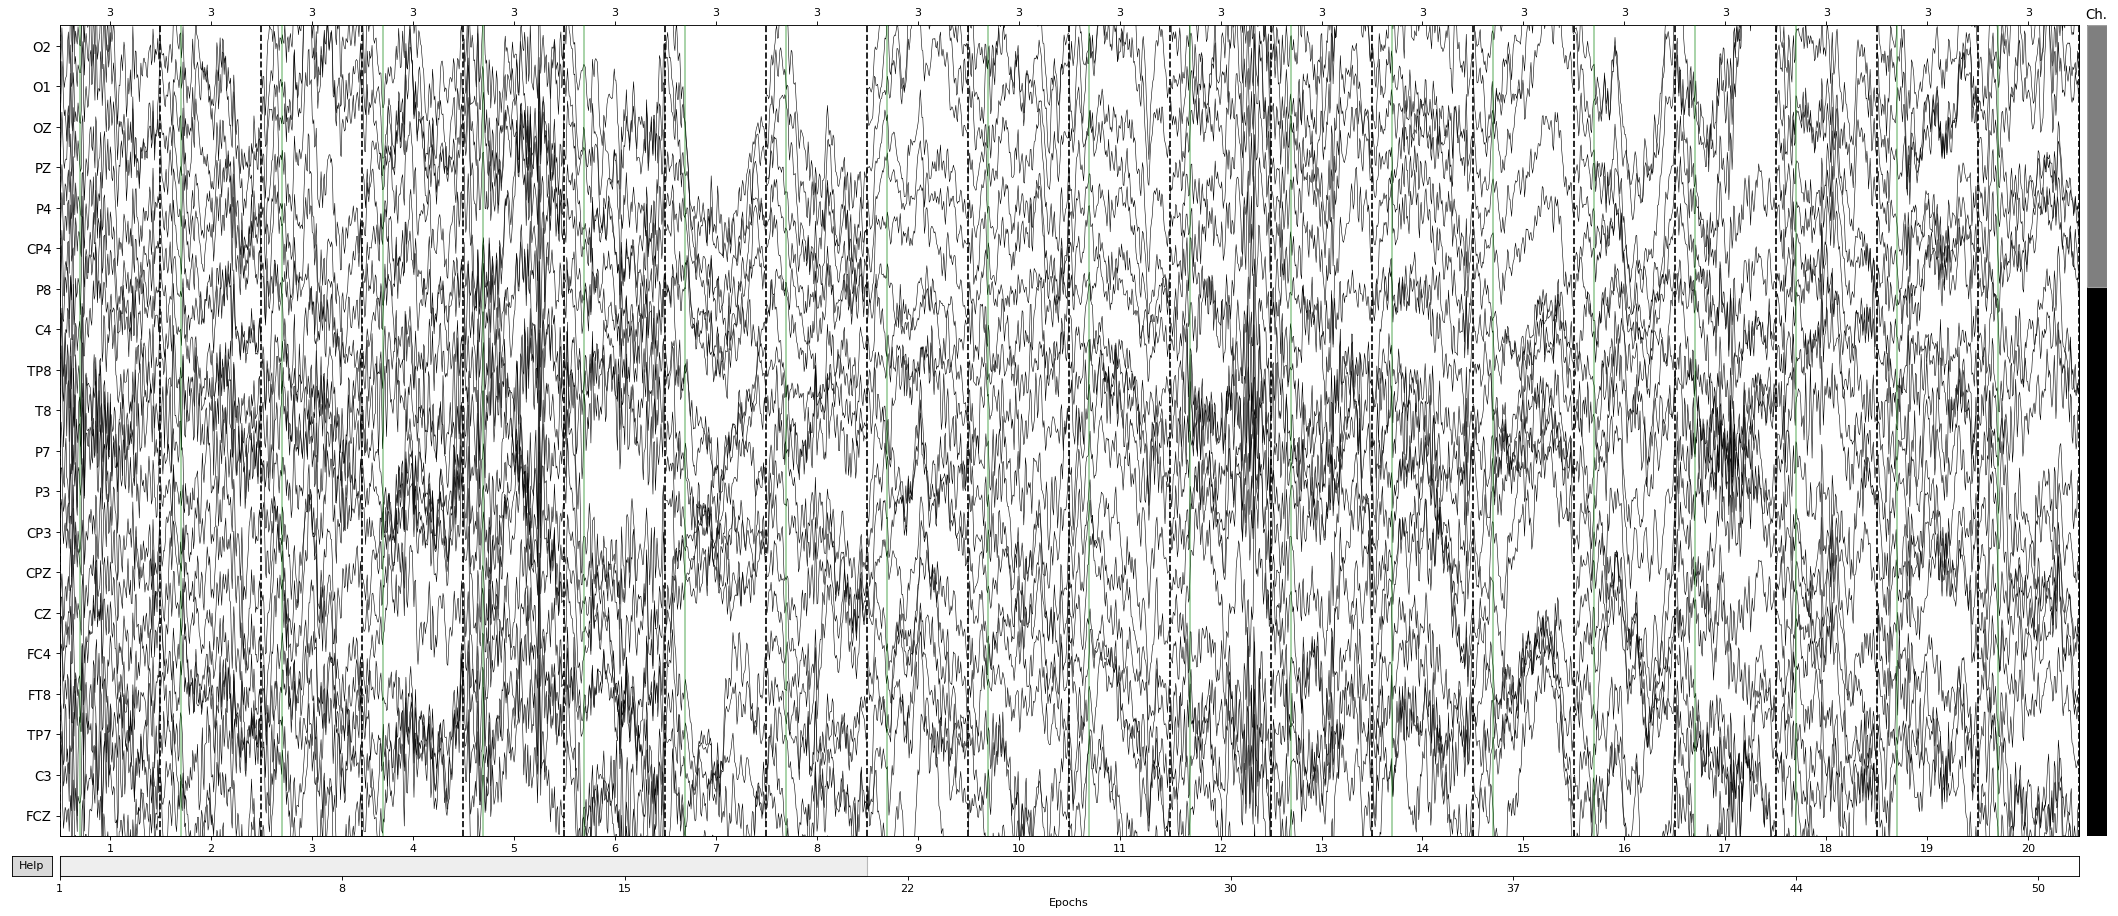

In [27]:
epochs['66'].plot()  # better done from IDE / editor to get interactive figure

### Get all individual episodes of one epoch as an array:

In [28]:
signals_66 = epochs['66'].get_data()

In [29]:
signals_66.shape

(50, 62, 501)

#  Workflow 'data cleaning'
### Detect outliers and 'bad' epochs

I here implemented a simple function to test all channels in all epochs for outliers (outliers with respect to STD and MIN-MAX difference of the signal within one epoch).

In [30]:
import helper_functions

bad_channels, bad_epochs = helper_functions.select_bad_epochs(epochs, 66, threshold = 5, max_bad_fraction = 0.2)

Found 7 bad epochs in a total of 2  channels.
Marked 7 bad epochs in a total of 50  epochs.


In [31]:
print(bad_channels) # print numbers of detected bad/suspicious channels
print(bad_epochs) # print numbers of detected bad/suspicious epochs

[]
[16, 49, 18, 6, 25, 42, 47]


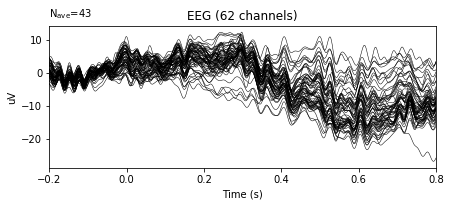

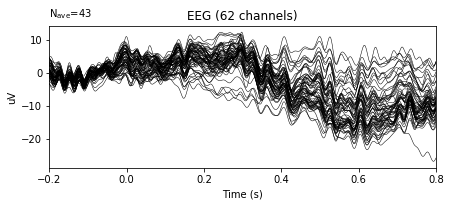

In [32]:
epochs['66'].drop(bad_epochs).average().plot()

#### Interpolate detected 'bad channels'

In [33]:
if len(bad_channels) > 0: 
    # Mark bad channels:
    data_raw.info['bads'] = bad_channels
    # Pick EEG channels:
    picks = mne.pick_types(data_raw.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude=[])
    epochs = mne.Epochs(data_raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=baseline, preload=True, verbose=False)
    # Interpolate bad channels using functionality of 'mne'
    epochs.interpolate_bads()
    

### Get cleaned EEG data as array
+ suspicious channels are interpolated
+ suspicious epochs are removed

In [34]:
signals_66_cleaned = epochs['66'].drop(bad_epochs).get_data()

In [35]:
signals_66_cleaned.shape

(43, 62, 501)

In [36]:
# Repeat for other simuli:
bad_channels, bad_epochs = helper_functions.select_bad_epochs(epochs, 13, threshold = 5, max_bad_fraction = 0.2)

Found 8 bad epochs in a total of 4  channels.
Marked 8 bad epochs in a total of 50  epochs.


In [37]:
signals_13_cleaned = epochs['13'].drop(bad_epochs).get_data()
print(signals_13_cleaned.shape)

(42, 62, 501)


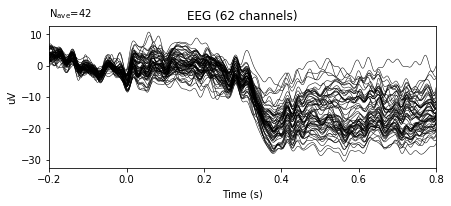

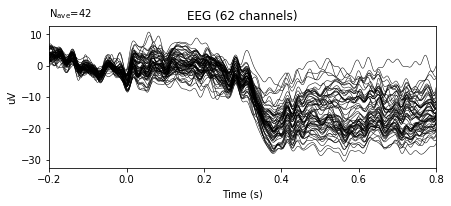

In [38]:
epochs['13'].drop(bad_epochs).average().plot()

Filtering options seem to be:
1. avoid removing channels --> remove more epochs
2. remove rather bad channels --> remove less epochs, but need to interpolate channels

#### Option 1: avoid removing channels --> remove more epochs

In [39]:
bad_channels, bad_epochs = helper_functions.select_bad_epochs(epochs, 3, threshold = 5, max_bad_fraction = 0.2)

Found 66 bad epochs in a total of 11  channels.
Marked 66 bad epochs in a total of 400  epochs.


In [40]:
signals_3_cleaned = epochs['3'].drop(bad_epochs).get_data()
print(signals_3_cleaned.shape)

(334, 62, 501)


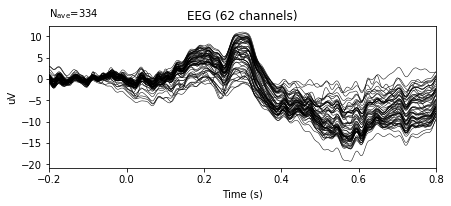

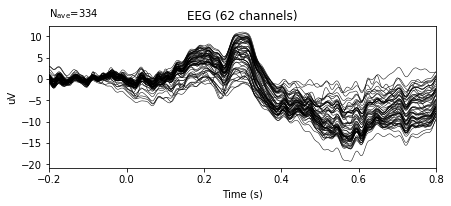

In [41]:
epochs['3'].drop(bad_epochs).average().plot()

#### Option 2: remove rather bad channels --> remove less epochs, but need to interpolate channel

In [42]:
bad_channels, bad_epochs = helper_functions.select_bad_epochs(epochs, 3, threshold = 5, max_bad_fraction = 0.1)

Found 66 bad epochs in a total of 11  channels.
Found bad channel (more than 40.0  bad epochs): Channel no:  31
Marked 22 bad epochs in a total of 400  epochs.


In [43]:
bad_channels, bad_epochs

(['PO3'],
 [256,
  129,
  385,
  318,
  4,
  388,
  77,
  141,
  143,
  23,
  221,
  96,
  288,
  228,
  166,
  232,
  233,
  366,
  375,
  376,
  380,
  382])

In [18]:
if len(bad_channels) > 0: 
    # Mark bad channels:
    data_raw.info['bads'] = bad_channels
    # Pick EEG channels:
    picks = mne.pick_types(data_raw.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude=[])
    epochs = mne.Epochs(data_raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=baseline, preload=True, verbose=False)
    # Interpolate bad channels using functionality of 'mne'
    epochs.interpolate_bads()

In [19]:
signals_3_cleaned2 = epochs['3'].drop(bad_epochs).get_data()
print(signals_3_cleaned2.shape)

(378, 62, 501)
